In [1]:
import numpy as np
from scipy import integrate
import torch

import matplotlib
import matplotlib.pyplot as plt

from probability_distribution import mu_gaussians, mu_display2D
from fourier_functions import Fourier_Functions, Fourier_Functions_Visualize2D
import pickle 

0.36791950647965144


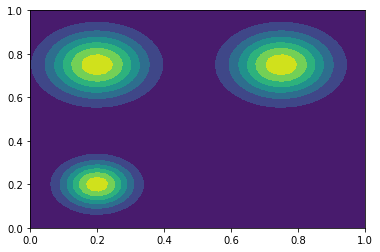

In [2]:
U_shape = (1,1)
p1 = mu_gaussians([(0.2, 0.01), (0.75, 0.02), (np.array([0.2, 0.75]), 0.02)], U_shape)
print(p1(np.array([0.2,0.3])))
mu_display2D(p1, U_shape)


In [3]:
mu = p1
K = 5
ff = Fourier_Functions(mu, U_shape, K, compute_mu=False, printProgress=True)
# for k in ff:
#     Fourier_Functions_Visualize2D(U_shape, ff[k])

with open(f'mu_k{K}.pkl', 'rb') as handle:
    mu_k = pickle.load(handle)
for k in ff:
    ff[k]['mu_k'] = mu_k[k]


Fourier Functions (mu, U_shape= (1, 1) , K= 5 )...
Computing constants (new_k, h_k, lambda_k)...
Computing torch fourier functions (f_k, df_k)...
Computing casadi fourier function (casadi_f_k)...
Aggregating all constants and functions into one dict...
Done.


In [4]:
from mm_agent import MMAgent1
from global_comm_agent_system import GlobalCommunicationSystem
from ergodic_agents import Agent, AgentSystem
# can only really test init rn
n = len(U_shape)
all_k = list(np.ndindex(*[K]*n))
agent1 = MMAgent1(0, np.array([0.2, 0.3]), 0.2, all_k, U_shape, ff, eps=1e-5)
# for k in agent1.k_bands:
#     print("mu"+str(k)+": ", ff[k]["mu_k"])
print("agent1 kbands: ", agent1.k_bands)
print("agent1 ck: ", agent1.get_c_k_log())
print("agent1 ergodicity: ", agent1.get_ergodicity_log())
print("agent1 position: ", agent1.get_position_log())
agent2 = MMAgent1(1, np.array([0.6, 0.5]), 0.2, all_k, U_shape, ff, eps=1e-5)
print(agent2.get_c_k_log())
print(agent2.get_ergodicity_log())
print(agent2.get_position_log())
print("system")
system1 = AgentSystem([agent1], mu, U_shape, ff, K)
print("system k_bands: ", list(system1.all_k_bands))
print("system c_k: ", system1.get_c_k_log())
print("system ergodicity: ", system1.get_ergodicity_log())

agent1 kbands:  [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
agent1 ck:  [{(0, 0): array(1.), (0, 1): array(0.83125388), (0, 2): array(-0.43701602), (0, 3): array(-1.34499702), (0, 4): array(-1.14412281), (1, 0): array(1.14412281), (1, 1): array(0.95105652), (1, 2): array(-0.5), (1, 3): array(-1.53884177), (1, 4): array(-1.30901699), (2, 0): array(0.43701602), (2, 1): array(0.36327126), (2, 2): array(-0.19098301), (2, 3): array(-0.58778525), (2, 4): array(-0.5), (3, 0): array(-0.43701602), (3, 1): array(-0.36327126), (3, 2): array(0.19098301), (3, 3): array(0.58778525), (3, 4): array(0.5), (4, 0): array(-1.14412281), (4, 1): array(-0.95105652), (4, 2): array(0.5), (4, 3): array(1.53884177), (4, 4): array(1.30901699)}]
agent1 ergodicity:  [0.79271308]
agent1 position:  [[0.2 0.3]]
[{(0, 0): array(1.), (0, 1): array(8.65956056e-17), (

In [5]:
t = 0
delta_t = 0.1
for i in range(100):
    t = i * delta_t
    system1.evolve(t, delta_t)


/home/enko/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional:  (2,)
additional

In [6]:
print("System vs Agent 1 c_k")
print(len(system1.c_k_log))
print(agent1.system_c_k)
print(len(agent1.c_k_log))
k = (1,2)
print([system1.c_k_log[i][k] - agent1.c_k_log[i][k] for i in range(5)])
print([system1.c_k_log[-i][k] - agent1.c_k_log[-i][k] for i in range(5)])

System vs Agent 1 c_k
101
None
101
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]


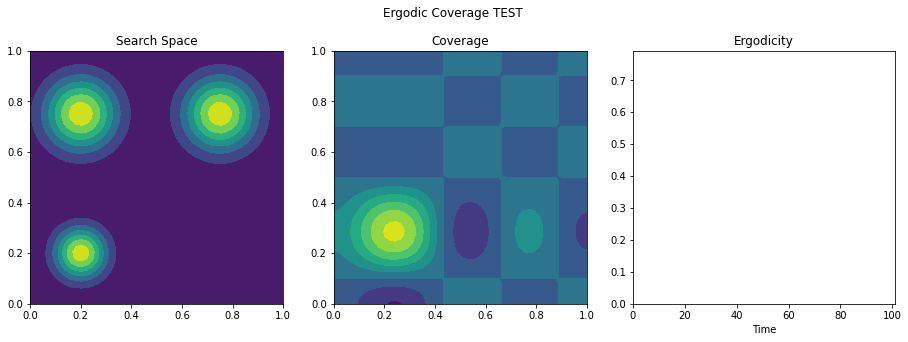

In [11]:
system1.visualize2d(filename="test_with_c_k", additional_title="TEST", plot_c_k=True)

In [7]:
def fourier_coefficient2distribution(ff, k_bands, c_k=None):
    def dist(x):
        res = 0
        for k in k_bands:
            if c_k is None:
                coeff_k = ff[k]['mu_k']
            else:
                coeff_k = c_k[k]
            res += coeff_k*ff[k]['f_k'](x)
        return res
    return dist

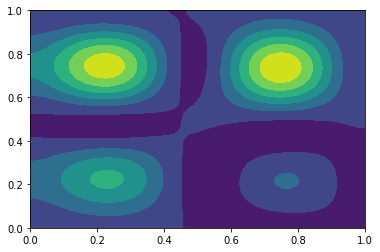

In [8]:
recon_mu = fourier_coefficient2distribution(ff, all_k)
mu_display2D(recon_mu, U_shape)

In [9]:
# i = 10
for i in [0, 20, 40, 60, 80, 100]:
    print("i: ", i)
    print(agent1.x_log[i])
    recon_c_k = fourier_coefficient2distribution(ff, all_k, agent1.c_k_log[i])
    mu_display2D(recon_c_k, U_shape)

i:  0
[0.2 0.3]
i:  20
[0.50041595 0.5626448 ]


In [ ]:
i = -1
print(agent1.x_log[i])
recon_c_k = fourier_coefficient2distribution(ff, all_k, agent1.c_k_log[i])
mu_display2D(recon_c_k, U_shape)

In [ ]:
def mu_time(t):
    return mu_gaussians([(np.array([0.2+0.05*t, 0.4]), 0.1/t), (np.array([0.8-0.1*t, 0.8]), 0.05), (np.array([0.8, 0.2]), 0.025)], (1,1))

for i in range(3):
    mu_display2D(mu_time(i+1), (1,1))